# Coffea Analysis of a NanoAOD MC dataset for CMS Run II (2018)

## Imports & reading

In [1]:
# imports

import uproot
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use([hep.style.CMS])
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema

In [2]:
# read the file
events = NanoEventsFactory.from_root('data.nosync/FirstOutputTest/GluGluToH_HToJPsiG_JPsiToMuMu_TuneCP5_13TeV-madgraph-pythia8_RunIISummer20UL18.root', schemaclass = NanoAODSchema.v7, treepath='mergedEvents').events()

/usr/local/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for FatJet_genJetAK8Idx => GenJetAK8
  warnings.warn(
/usr/local/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx1 => SubJet
  warnings.warn(
/usr/local/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx2 => SubJet
  warnings.warn(
/usr/local/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for GenVisTau_genPartIdxMother => GenPart
  warnings.warn(
/usr/local/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:200: RuntimeWarning: Missing cross-reference target for Jet_genJetIdx => GenJet
  warnings.warn(


In [3]:
# show the available contents for each of the events

events.fields

['puWeightDown',
 'cosTheta1',
 'LHE',
 'is2018',
 'OtherPV',
 'GenIsolatedPhoton',
 'is2016',
 'minMuonPfIso',
 'leptonWeight',
 'puWeightUp',
 'lumiWeight',
 'triggerMuonEGWeight',
 'luminosityBlock',
 'triggerJPsiWeight',
 'vbfDR',
 'DeepMETResolutionTune',
 'ewknloWeight',
 'triggerWeightDown',
 'genCosThetaStar',
 'leptonWeightUp',
 'genCosTheta1',
 'isMC',
 'eventJPsiWeightLumi',
 'passedMETFilters',
 'PV',
 'H',
 'nCleanForwardJet',
 'DeepMETResponseTune',
 'genWeight',
 'LHEReweightingWeight',
 'Electron',
 'LHEPart',
 'maxMuonPfIso',
 'MET',
 'HLTriggerFinalPath',
 'triggerMuonEGWeightDown',
 'SoftActivityJet',
 'maxMuonPfSubIso',
 'vbfMjj',
 'metPlusPhotonDPhi',
 'TkMET',
 'CaloMET',
 'Jet',
 'isJPsiTrigger',
 'Photon',
 'nCleanPhoton',
 'Tau',
 'Flag',
 'genPhi1',
 'Muon12',
 'isDisplacedTrigger',
 'SoftActivityJetHT',
 'nCleanCentralJet',
 'qcdnnloWeight',
 'triggerJPsiWeightUp',
 'iMuon1',
 'L1PreFiringWeight',
 'triggerMuonEGWeightUp',
 'SoftActivityJetNjets5',
 'Muon1',


## Filtering the events

Selection cuts:
* Muons:
    * $ p_{T} > 18$ GeV
    * ~~p_T < 1000 GeV~~
    * Muon1_pt > 5 GeV
    * Muon2_pt > 5 GeV
    * Muon1_mediumPromptId && Muon2_mediumPromptId
    * minMuonPfIso < 0.15 && maxMuonPfIso < 0.15
    * $|\eta| < 2.4$
* Photons: 
    * $ p_{T} > 30 $ GeV
    * Photon1_pt > 15 GeV
    * Photon1_mvaID_WP80
    * Photon1_pixelSeed == 0
    * ~~R_9 < 4~~


In [4]:
leadingMuon_pt_cut = 17
subleadingMuon_pt_cut = 4
#maximum_muon_pt = 1000
muon_eta_cut = 2.4
photon_pt_cut = 30
#maximum_r9 = 4

In [5]:
print(events[ak.num(events.Muon) > 3].Muon.charge)

[[1, -1, -1, -1], [1, -1, 1, 1], [-1, 1, ... [-1, 1, -1, 1, -1], [-1, 1, -1, -1]]


In [6]:
# muon filters
basic_muon_filters = (ak.num(events.Muon) >= 2) & (events.Muon1.pt > 5.) & (events.Muon2.pt > 5.) & (events.Muon1.mediumPromptId == 1) & (events.Muon2.mediumPromptId == 1) & (events.minMuonPfIso < 0.15) & (events.maxMuonPfIso < 0.15)

leadingMuon_withAtLeast_17GeV = ak.sum(events.Muon.pt > leadingMuon_pt_cut, axis = -1) >= 1 # at least one muon with 17 GeV
subleadingMuon_withAtLeast_4GeV = ak.sum(events.Muon.pt > subleadingMuon_pt_cut, axis = -1) >= 2 # secondary muon with at least 4 GeV
                                                                                                 # note that we demand to be at least 2
                                                                                                 # because the leading muon will also pass this cut

# atMost_Muon_pt_is_1000 = ak.all(events.Muon.pt < maximum_muon_pt, axis = -1)
# muon_opposite_charges = ak.sum(events.Muon.charge, axis = -1) == 0


muon_filters = basic_muon_filters & leadingMuon_withAtLeast_17GeV & subleadingMuon_withAtLeast_4GeV # & muon_opposite_charges #& atMost_Muon_pt_is_1000


# photon filters
basic_photon_filters = (ak.num(events.Muon) >= 1) &  (events.Photon1.pt > 15.) & (events.Photon1.mvaID_WP80 == 1) & (events.Photon1.pixelSeed == 0)

atLeast_one_photon_with_30GeV = ak.any(events.Photon.pt > photon_pt_cut, axis = -1)
#atMost_Photon_r9_is_5 = ak.all(events.Photon.r9 < maximum_r9, axis = -1) # events with a photon having r9 > 5 will be discarded

photon_filters = basic_photon_filters & atLeast_one_photon_with_30GeV #& atMost_Photon_r9_is_5


# selected events
event_filters = muon_filters & photon_filters
selected_events = events[event_filters]

print("The events that satisfy all the requirements are the %.1f%%" % (len(selected_events) / len(events) * 100))

The events that satisfy all the requirements are the 46.1%


In [7]:
# apply the filters

selected_muons = events.Muon[muon_filters]
selected_photons = events.Photon[photon_filters]

## Plots

### Muon $p_{T}$

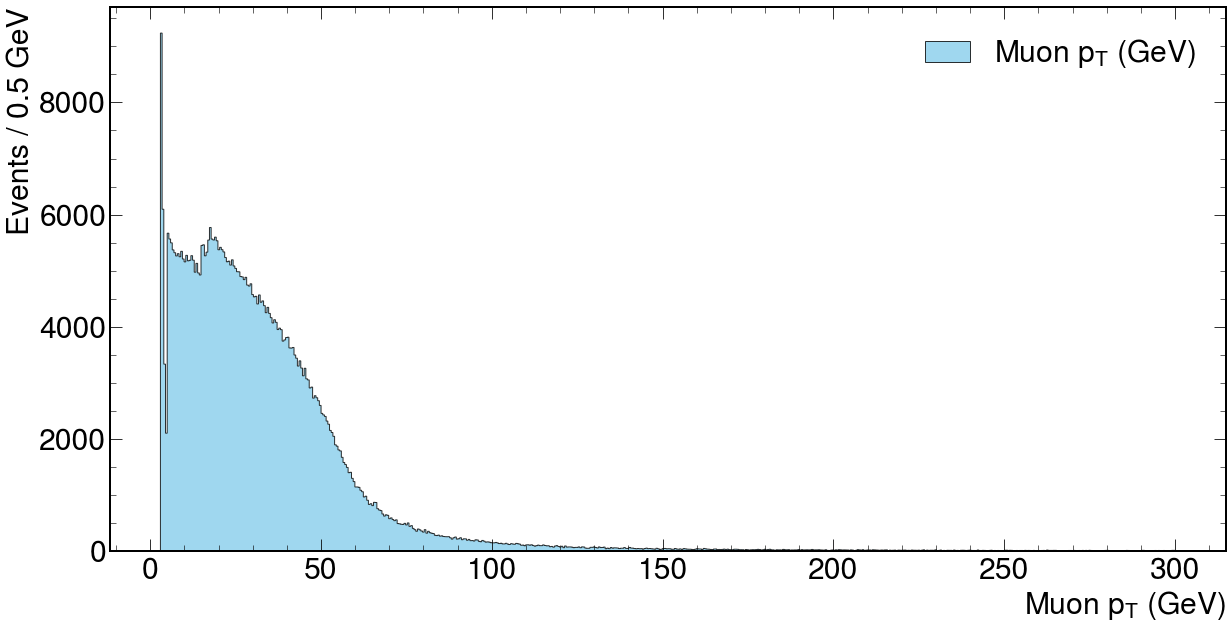

In [8]:
min = 0
max = 300
width = .5 # GeV
nbins = int(round((max - min) / width))

obs =  ak.flatten(selected_events.Muon.pt[(selected_events.Muon.pt > min) & (selected_events.Muon.pt < max)], axis = None)

fig, ax = plt.subplots(figsize=(20, 10))
ax.hist(
    obs,
    bins = nbins,
    histtype = "stepfilled",
    color = "skyblue",
    alpha = 0.8,
    edgecolor = "black",
    label = r"Muon $p_{T}$ (GeV)"
)
#ax.set_yscale("log")
ax.tick_params(axis = 'both', which = 'major', labelsize = 30)
ax.set_xlabel("Muon $p_{T}$ (GeV)", fontsize = 30)
ax.set_ylabel("Events / %.1f GeV" % width, fontsize = 30)
#ax.set_xlim(min, max)
#ax.set_ylim(0, 5)
ax.legend(loc = "best", fontsize = 30)

### Photon $p_{T}$

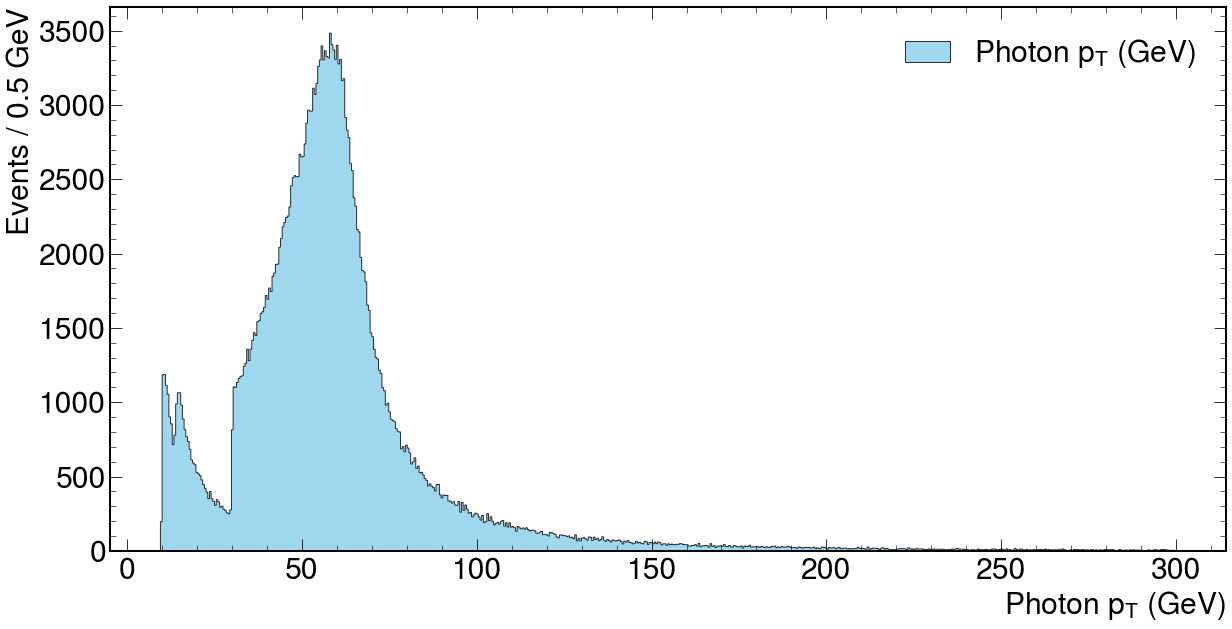

In [9]:
min = 0
max = 300
width = .5 # GeV
nbins = int(round((max - min) / width))

obs =  ak.flatten(selected_events.Photon.pt[(selected_events.Photon.pt > min) & (selected_events.Photon.pt < max)], axis = None)

fig, ax = plt.subplots(figsize=(20, 10))
ax.hist(
    obs,
    bins = nbins,
    histtype = "stepfilled",
    color = "skyblue",
    alpha = 0.8,
    edgecolor = "black",
    label = r"Photon $p_{T}$ (GeV)"
)
#ax.set_yscale("log")
ax.tick_params(axis = 'both', which = 'major', labelsize = 30)
ax.set_xlabel("Photon $p_{T}$ (GeV)", fontsize = 30)
ax.set_ylabel("Events / %.1f GeV" % width, fontsize = 30)
#ax.set_xlim(min, max)
#ax.set_ylim(0, 5)
ax.legend(loc = "best", fontsize = 30)

### Photon quality

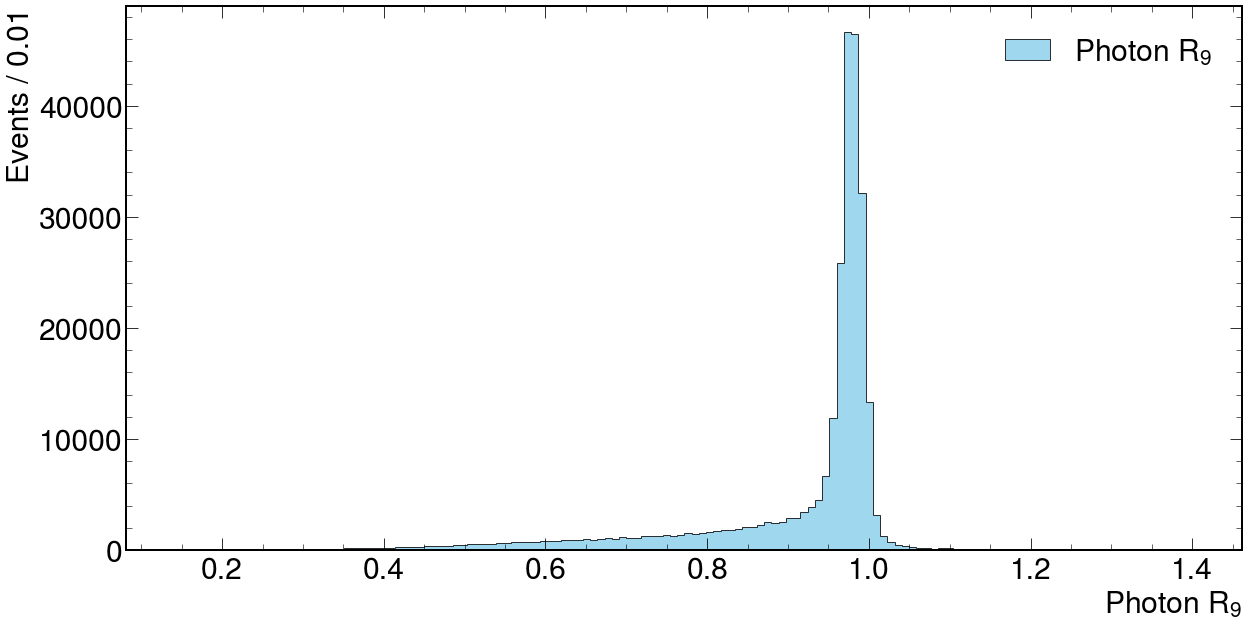

In [10]:
min = 0
max = 1.4
width = .01 # GeV
nbins = int(round((max - min) / width))

obs =  ak.flatten(selected_events.Photon.r9[(selected_events.Photon.r9 > min) & (selected_events.Photon.r9 < max)], axis = None)

fig, ax = plt.subplots(figsize=(20, 10))
ax.hist(
    obs,
    bins = nbins,
    histtype = "stepfilled",
    color = "skyblue",
    alpha = 0.8,
    edgecolor = "black",
    label = r"Photon $R_{9}$"
)
#ax.set_yscale("log")
ax.tick_params(axis = 'both', which = 'major', labelsize = 30)
ax.set_xlabel("Photon $R_{9}$", fontsize = 30)
ax.set_ylabel("Events / %.2f" % width, fontsize = 30)
#ax.set_xlim(min, max)
#ax.set_ylim(0, 5)
ax.legend(loc = "best", fontsize = 30)

### Invariant $\mu\mu$ mass

In [11]:
muon_theta = 2 * np.arctan(np.exp(selected_events.Muon.eta))
muon_theta

<Array [[0.236, 0.26, 0.259], ... [2.09, 2.01]] type='234969 * var * float32'>

In [12]:
# module of P
muon_P = selected_events.Muon.pt / np.sin(muon_theta)

# 3-components of P
muon_Px = muon_P * np.sin(muon_theta) * np.cos(selected_events.Muon.phi)
muon_Py = muon_P * np.sin(muon_theta) * np.sin(selected_events.Muon.phi)
muon_Pz = muon_P * np.cos(muon_theta)

# energy of muon
muon_e = (selected_events.Muon.mass ** 2 + muon_P ** 2) ** 0.5

In [13]:
# 3-components of the mumu system' P
mumu_Px = ak.sum(muon_Px, axis = -1)
mumu_Py = ak.sum(muon_Py, axis = -1)
mumu_Pz = ak.sum(muon_Pz, axis = -1)
mumu_e = ak.sum(muon_e, axis = -1)

# invariant mass of mumu system
mumu_m = (mumu_e ** 2 - mumu_Px ** 2 - mumu_Py ** 2 - mumu_Pz ** 2) ** 0.5

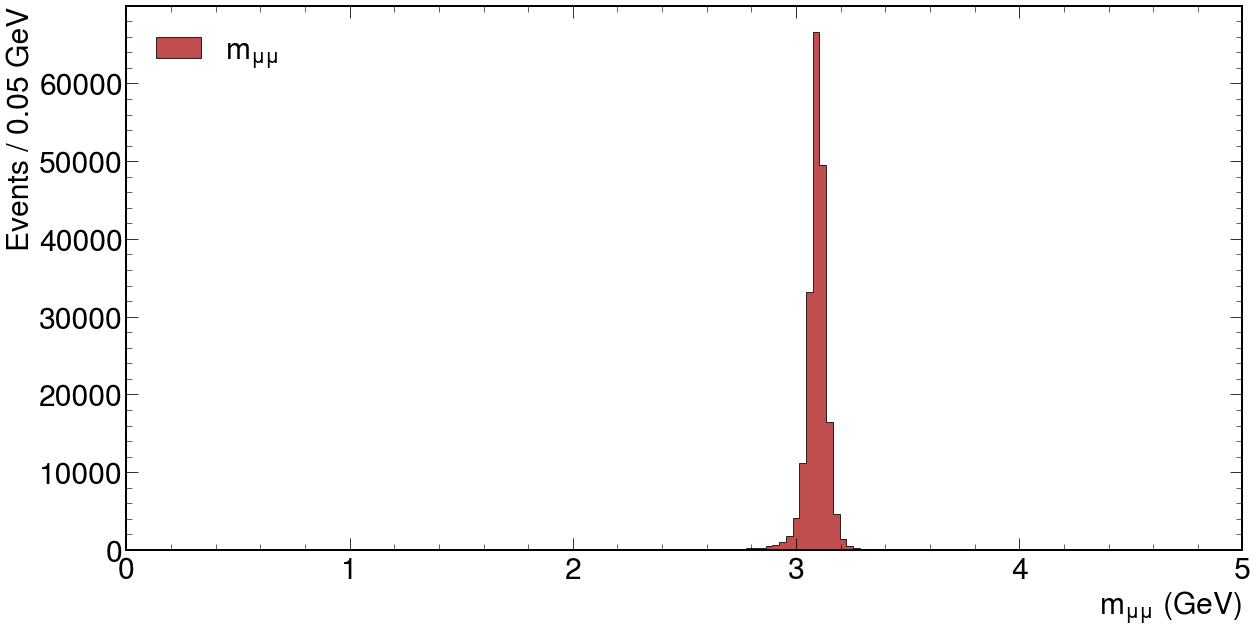

In [14]:
min = 0
max = 5
width = 0.05 # GeV
nbins = int(round((max - min) / width))

obs = ak.flatten(mumu_m[(mumu_m > min) & (mumu_m < max)], axis = None)

fig, ax = plt.subplots(figsize=(20, 10))
ax.hist(
    obs,
    bins = nbins,
    histtype = "stepfilled",
    color = "firebrick",
    alpha = 0.8,
    edgecolor = "black",
    label = r"$m_{\mu \mu}$"
)
#ax.set_yscale("log")
ax.tick_params(axis = 'both', which = 'major', labelsize = 30)
ax.set_xlabel("$m_{\mu \mu}\ ({\\rm GeV})$", fontsize = 30)
ax.set_ylabel("Events / %.2f GeV" % width, fontsize = 30)
ax.set_xlim(min, max)
#ax.set_ylim(0, 5)
ax.legend(loc = "best", fontsize = 30)

### Invariant $\mu \mu \gamma$ mass

In [15]:
photon_theta = 2 * np.arctan(np.exp(selected_events.Photon.eta))
photon_theta

<Array [[0.882, 0.843], ... 2.84], [2.01]] type='234969 * var * float32'>

In [16]:
# module of P
photon_P = selected_events.Photon.pt / np.sin(photon_theta)

# 3-components of P
photon_Px = photon_P * np.sin(photon_theta) * np.cos(selected_events.Photon.phi)
photon_Py = photon_P * np.sin(photon_theta) * np.sin(selected_events.Photon.phi)
photon_Pz = photon_P * np.cos(photon_theta)

# energy of photon
photon_e = photon_P

In [17]:
# 3-components of the mumuG system' P
mumuG_Px = mumu_Px + photon_Px
mumuG_Py = mumu_Py + photon_Py
mumuG_Pz = mumu_Pz + photon_Pz
mumuG_e = mumu_e + photon_e

# invariant mass of mumu system
mumuG_m = (mumuG_e ** 2 - mumuG_Px ** 2 - mumuG_Py ** 2 - mumuG_Pz ** 2) ** 0.5

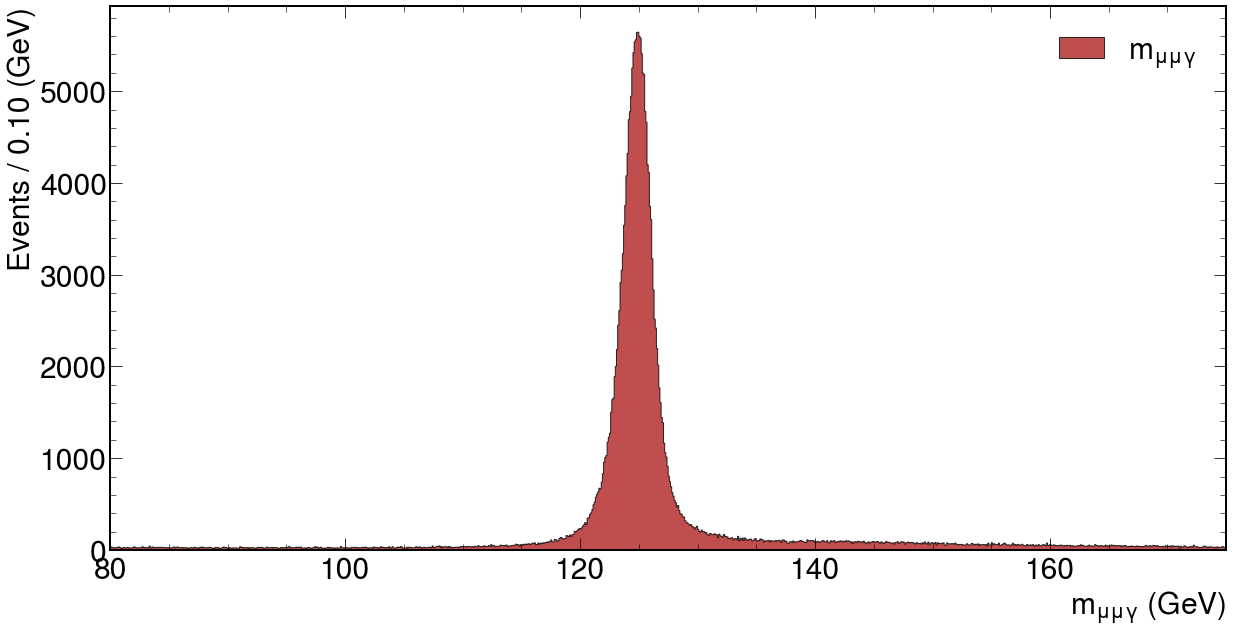

In [18]:
min = 80
max = 175
width = 0.1 # GeV
nbins = int(round((max - min) / width))

obs = ak.flatten(mumuG_m[(mumuG_m > min) & (mumuG_m < max)], axis = None)

fig, ax = plt.subplots(figsize=(20, 10))
ax.hist(
    obs,
    bins = nbins,
    histtype = "stepfilled",
    color = "firebrick",
    alpha = 0.8,
    edgecolor = "black",
    label = r"$m_{\mu \mu \gamma}$"
)
#ax.set_yscale("log")
ax.tick_params(axis = 'both', which = 'major', labelsize = 30)
ax.set_xlabel("$m_{\mu \mu \gamma}\ ({\\rm GeV})$", fontsize = 30)
ax.set_ylabel("Events / %.2f (GeV)" % width, fontsize = 30)
ax.set_xlim(min, max)
#ax.set_ylim(0, 5)
ax.legend(loc = "best", fontsize = 30)

## Signal efficiency: efficiency of the trigger path (HLT_Mu17_Photon30) with respect to the desired signal

In [19]:
den = ak.sum( ak.any(events.Muon.pt > leadingMuon_pt_cut, axis = -1) & ak.any(events.Photon.pt > photon_pt_cut, axis = -1))
num = ak.sum( ak.any(events.Muon[events.HLT.Mu17_Photon30_IsoCaloId].pt > leadingMuon_pt_cut, axis = -1) & ak.any(events.Photon[events.HLT.Mu17_Photon30_IsoCaloId].pt > photon_pt_cut, axis = -1))

In [20]:
trig_eff = num / den * 100
print("The trigger efficiency is %.1f%%" % trig_eff)

The trigger efficiency is 85.2%
